In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gene-expression-prediction-cs1850-final/sample_submission.csv
/kaggle/input/gene-expression-prediction-cs1850-final/train.npz
/kaggle/input/gene-expression-prediction-cs1850-final/info.py
/kaggle/input/gene-expression-prediction-cs1850-final/eval.npz
/kaggle/input/gene-expression-prediction-cs1850-final/seq_data.csv


In [24]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
#preview submission format

sub = pd.read_csv('/kaggle/input/gene-expression-prediction-cs1850-final/sample_submission.csv')
sub.head()

,id,expression
0,E065_115459,-0.062554
1,E065_162723,-0.083605
2,E065_196275,-0.575977
3,E065_232774,-0.233146
4,E065_172339,0.279043


In [4]:
sub.shape

(177032, 2)

In [5]:
#preview info file

with open ('/kaggle/input/gene-expression-prediction-cs1850-final/info.py','r') as f:
    print(f.read())

import numpy as np

# Keys to npzfile of train & eval
train_cells = ['E065', 'E004', 'E066', 'E005', 'E012', 'E027', 'E053', 'E013', 'E028', 'E061', 'E109', 'E120', 'E062', 'E037', 'E038', 'E024', 'E105', 'E011', 'E106', 'E082', 'E097', 'E116', 'E098', 'E058', 
'E117', 'E059', 'E070', 'E118', 'E085', 'E104', 'E119', 'E006', 'E127', 'E047', 'E094', 'E007', 'E054', 'E128', 'E095', 'E055', 'E114', 'E100', 'E056', 'E016', 'E122', 'E057', 'E123', 'E079', 'E003', 'E050']

eval_cells = ['E065', 'E004', 'E066', 'E005', 'E012', 'E027', 'E053', 'E013', 'E028', 'E061', 'E109', 'E120', 'E062', 'E037', 'E038', 'E024', 'E071', 'E105', 'E087', 'E011', 'E106', 'E096', 'E082', 'E097', 
'E116', 'E098', 'E058', 'E117', 'E084', 'E059', 'E070', 'E118', 'E085', 'E104', 'E119', 'E006', 'E112', 'E127', 'E047', 'E094', 'E007', 'E054', 'E113', 'E128', 'E095', 'E055', 'E114', 'E100', 'E056', 'E016', 'E122', 'E057', 'E123', 'E079', 'E003', 'E050']

# Load data
train_data = np.load('train.npz')
eval_data = np.load

In [6]:
#load training data
train_data = np.load('/kaggle/input/gene-expression-prediction-cs1850-final/train.npz',allow_pickle=True)
len(train_data.files)

50

In [7]:
eval_data = np.load('/kaggle/input/gene-expression-prediction-cs1850-final/eval.npz',allow_pickle=True)
len(eval_data.files)

56

In [8]:
#Explore the training data
train_data.files[:5]

['E065', 'E004', 'E066', 'E005', 'E012']

In [9]:
#select one cell type and check its shape
E065 = train_data['E065']
E065.shape

(16000, 100, 7)

In [10]:
#preview the 1st gene, second bin, all columns of E065 cell type
E065[0,1,:]

array([ 3.       ,  0.       ,  0.6931472,  0.       ,  0.       ,
        0.6931472, -2.9263823], dtype=float32)

- **First column:** gene ID
- **Second-sixth columns:** histone modification measurements
- **Seventh column:** gene expression

In [11]:
# Gene ID is constant across bins
print(np.unique(E065[0, :, 0]))

# Expression value is constant across bins
print(np.unique(E065[0, :, 6]))

[3.]
[-2.9263823]


In [12]:
# Separate target and features
histone_features = E065[:,:,1:6]
Expression = E065[:,:,6]
print(histone_features.shape)
print(Expression.shape)

(16000, 100, 5)
(16000, 100)


- 16000 genes
- 100 bins
- 5 histone markers

In [13]:
# Keys to npzfile of train & eval
train_cells = ['E065', 'E004', 'E066', 'E005', 'E012', 'E027', 'E053', 'E013', 'E028', 'E061', 'E109', 'E120',
               'E062', 'E037', 'E038', 'E024', 'E105', 'E011', 'E106', 'E082', 'E097', 'E116', 'E098', 'E058', 
'E117', 'E059', 'E070', 'E118', 'E085', 'E104', 'E119', 'E006', 'E127', 'E047', 'E094', 'E007', 'E054', 'E128',
               'E095', 'E055', 'E114', 'E100', 'E056', 'E016', 'E122', 'E057', 'E123', 'E079', 'E003', 'E050']

eval_cells = ['E065', 'E004', 'E066', 'E005', 'E012', 'E027', 'E053', 'E013', 'E028', 'E061', 'E109', 'E120', 
              'E062', 'E037', 'E038', 'E024', 'E071', 'E105', 'E087', 'E011', 'E106', 'E096', 'E082', 'E097', 
'E116', 'E098', 'E058', 'E117', 'E084', 'E059', 'E070', 'E118', 'E085', 'E104', 'E119', 'E006', 'E112', 'E127',
              'E047', 'E094', 'E007', 'E054', 'E113', 'E128', 'E095', 'E055', 'E114', 'E100', 'E056', 'E016', 'E122',
              'E057', 'E123', 'E079', 'E003', 'E050']

In [14]:
# Combine Train Data to use information from all cells
train_inputs = [] # Input histone mark data
train_outputs = [] # Correct expression value
for cell in train_cells:
    cell_data = train_data[cell]
    hm_data = cell_data[:,:,1:6]
    hm_flat = hm_data.reshape(hm_data.shape[0], -1)
    exp_values = cell_data[:,0,6]
    train_inputs.append(hm_flat)
    train_outputs.append(exp_values)

train_inputs = np.concatenate(train_inputs, axis=0)
train_outputs = np.concatenate(train_outputs, axis=0)

In [15]:
print(train_inputs.shape)
print(train_outputs.shape)

(800000, 500)
(800000,)


In [16]:
# Prepare Eval inputs in a similar way
eval_inputs = []
for cell in eval_cells:
    cell_data = eval_data[cell]
    hm_data = cell_data[:,:,1:6]
    hm_flat = hm_data.reshape(hm_data.shape[0], -1)
    eval_inputs.append(hm_flat)

eval_inputs = np.concatenate(eval_inputs, axis=0)

In [17]:
print(eval_inputs.shape)

(177032, 500)


In [18]:
#explore the expression values statistically

print("Mean:", np.mean(train_outputs))
print("Std:", np.std(train_outputs))
print("Min:", np.min(train_outputs))
print("Max:", np.max(train_outputs))

Mean: -0.27236924
Std: 1.8670437
Min: -5.204512
Max: 10.710043


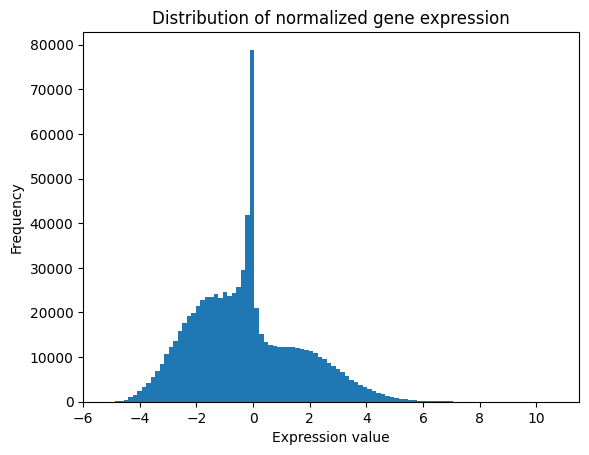

In [19]:
# visualize the distribution
plt.hist(train_outputs, bins=100)
plt.xlabel("Expression value")
plt.ylabel("Frequency")
plt.title("Distribution of normalized gene expression")
plt.show()

# Model Building

### Baseline Model

In [20]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(train_inputs,train_outputs,test_size=0.2, random_state=42)

In [21]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(640000, 500)
(160000, 500)
(640000,)
(160000,)


In [22]:
model = Ridge(alpha=1.0)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MSE:", mse)
print("R²:", r2)

MSE: 3.3424179553985596
R²: 0.04120439291000366


# Build 1D CNN model

In [23]:
#converting the training data shape back to its original shape
X = train_inputs.reshape(800000, 100, 5)
#converting the evaluation data shape back to its original shape
y = train_outputs

In [25]:
#scaling the target
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).ravel()

In [26]:
#train/validate split
X_train, X_val, y_train, y_val = train_test_split(X, y_scaled, test_size=0.2, random_state=42)